# Corrección extremal por Weather Types para el Storm Surge 

En este notebook, se aplica la corrección extremal tomando como extremos los máximos anuales.

Librerias:

In [32]:
import numpy as np
import pandas as pd
import os
import sys
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import xarray as xr
import numdifftools as ndt
from scipy import stats 

path = r"C:\Users\user\Victor\Trabajo\NoEstacionario\Python"
variable = "SS"
os.chdir(path)
os.getcwd()

'C:\\Users\\user\\Victor\\Trabajo\\NoEstacionario\\Python'

## Tratamiento de datos

Carga de datos históricos del Storm Surge

In [5]:
data = pd.read_table("Datos\\DatosSimulados_10000y\\Hs_SS_PCs_FWT_LWT_Precip_Cantabria_reg_guided.txt")

# Columns for the Surge dataframe
cols_ss = ['yyyy', 'mm', 'dd', 'Surge'] + [col for col in data.columns if col.endswith('_SS')] + ['LWT']
# Dataframe with Storm Surge Data
df_surge = data[cols_ss]

Añadimos la variable `time` en escala anual al dataframe.

In [6]:
# Define the days in a month dictionary
days_in_month = {1: 31, 2: 28.25, 3: 31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

# Correct the time assignment for df_surge
df_surge = df_surge.copy()  # Ensure it's a copy, avoiding modifying the original DataFrame slice
df_surge['time'] = (
    df_surge['yyyy'] - np.min(df_surge['yyyy'])
    + (df_surge['mm'] - 1) / 12
    + df_surge['dd'] / df_surge['mm'].map(days_in_month) / 12
)
df_surge.head()

,yyyy,mm,dd,Surge,PC0_SS,PC1_SS,PC2_SS,PC3_SS,PC4_SS,PC5_SS,...,PC67_SS,PC68_SS,PC69_SS,PC70_SS,PC71_SS,PC72_SS,PC73_SS,PC74_SS,LWT,time
0,1979,1,1,-0.059125,4.563096,-1.148158,-4.716766,-1.764629,-0.951826,-0.921911,...,-0.001808,-0.003190,0.000548,-0.006154,-0.008700,0.000939,-0.004016,0.000593,0,0.002688
1,1979,1,2,-0.107542,1.435022,4.178313,-6.377257,0.301036,0.179441,0.755001,...,0.000203,-0.001587,-0.000242,0.000403,0.000597,-0.001703,0.001418,-0.000744,3,0.005376
2,1979,1,3,0.128542,11.467402,12.111176,4.108900,3.547797,0.623457,2.743755,...,-0.001919,-0.006954,0.004526,-0.000502,-0.003448,0.002078,0.008224,-0.001982,14,0.008065
3,1979,1,4,0.215208,22.532380,6.687920,5.921004,-1.244041,0.653301,-0.374813,...,-0.002443,0.001002,0.003585,0.001733,-0.001514,0.001234,-0.000144,0.000159,6,0.010753
4,1979,1,5,0.056542,10.146863,-4.813095,-5.141751,0.105141,0.934230,-0.422162,...,0.001845,-0.002186,0.000825,0.001760,0.000370,-0.003263,-0.000107,-0.000279,5,0.013441


Rango de los Weather Types y probabilidad de aparición de cada WT.

In [7]:
wt_probs = df_surge['LWT'].value_counts(normalize=True).sort_index()
wt_range = np.sort(df_surge['LWT'].unique())

Diccionario con los datos separados para cada WT.

In [12]:
dict_ss = {}
for idx_wt, wt in enumerate(wt_range):
    dict_ss[idx_wt] = df_surge[:][df_surge['LWT'] == idx_wt]

Obtención de los máximos anuales 

In [16]:
# Yearly maxima
ss_max_data = {}
max_idx = {}

for idx_wt, wt in enumerate(wt_range):
    ss_max_data[idx_wt] = dict_ss[idx_wt].groupby(["yyyy"], as_index=False)["Surge"].max()  # Máximo anual Hs para cada WT
    max_idx[idx_wt] = dict_ss[idx_wt].groupby(["yyyy"])["Surge"].idxmax().values            # Indice del máximo anual por WT

n_return_period = 365.25*wt_probs   # Nº de días de aparición de cada WT al año

Datos ordenados

In [17]:
ss_max_data_sorted = {}
sorted_max_idx = {}
for idx_wt, wt in enumerate(wt_range):
    ss_max_data_sorted[idx_wt] = np.sort(ss_max_data[idx_wt]['Surge'])
    sorted_max_idx[idx_wt] = np.argsort(ss_max_data[idx_wt]['Surge'])

Datos de point-in-time para cada WT

In [18]:
ss_pt = {}
ss_pt_sort = {}
# SS point-in-time data per WT
for idx_wt, wt in enumerate(wt_range):
    ss_pt[idx_wt] = dict_ss[idx_wt]['Surge'].values
    ss_pt_sort[idx_wt] = np.sort(dict_ss[idx_wt]['Surge'].values)

## Periódos de retorno empíricos para cada WT.

Cálculo de la Función Empírica y sus periodos de retorno asociados para los datos diarios y los máximos anuales en cada WT. 

A la hora del cálculo de los "periodos de retorno" diarios, hay que dividirlos por la media de apariciones de ese WT en un año. Es decir, 
$$
365.25*P(\text{Aparición WT}_j) \;\text{para}\;j=0,\dots,15.
$$

En nuestro caso, $P(\text{Aparición WT}_j) =$ `n_return_period[j]`.

In [19]:
ecdf_pt_probs= {}
T_pt = {}
ecdf_ev_probs_wt = {}
T_ev_wt = {}

for idx_wt, wt in enumerate(wt_range):
    # Empirical df and Return period for point in time
    ecdf_pt_probs[idx_wt] = np.arange(1,len(ss_pt[idx_wt])+1)/(len(ss_pt[idx_wt])+1)
    T_pt[idx_wt] = 1/(1-ecdf_pt_probs[idx_wt])/n_return_period[idx_wt]

    # Empirical df and Return period for monthly maxima
    ecdf_ev_probs_wt[idx_wt] = np.arange(1,len(ss_max_data[idx_wt])+1)/(len(ss_max_data[idx_wt])+1)
    T_ev_wt[idx_wt] = 1/(1-ecdf_ev_probs_wt[idx_wt])

Gráfico de periodos de retorno para cada WT. En este gráfico se puede ver cómo los "periodos de retorno" diarios convergen a los periodos de retorno anuales.

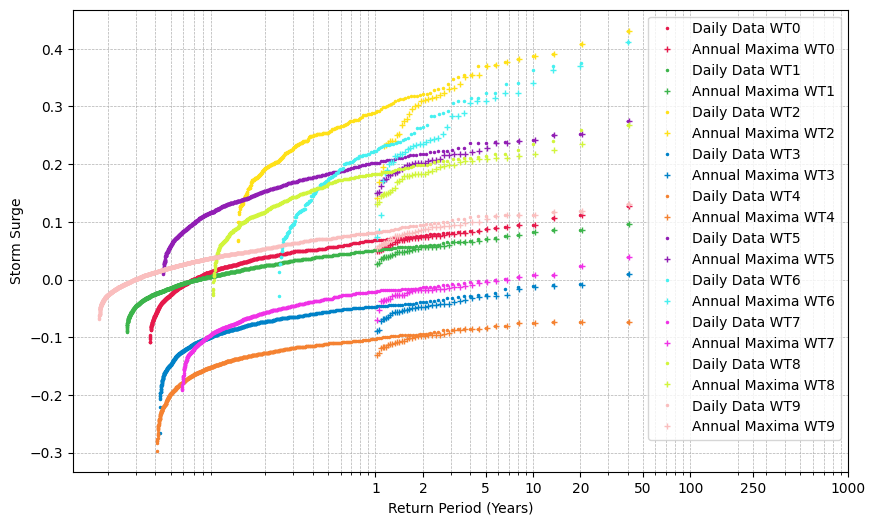

In [24]:
colors = [
    '#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4',
    '#46f0f0', '#f032e6', '#d2f53c', '#fabebe', '#008080', '#e6beff',
    '#aa6e28', '#fffac8', '#800000', '#aaffc3'
]

fig = plt.figure(figsize=(10,6))
ax= fig.add_subplot()
for idx_wt in range(10):
    ax.semilogx(T_pt[idx_wt], ss_pt_sort[idx_wt], linewidth=0, color=colors[idx_wt], marker='o',markersize=1.5, label=f'Daily Data WT{idx_wt}')
    ax.semilogx(T_ev_wt[idx_wt], ss_max_data_sorted[idx_wt], color=colors[idx_wt], linewidth=0, marker='+',markersize=5, label=f'Annual Maxima WT{idx_wt}')

# Configurar escala logarítmica y ticks personalizados
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())  # Mantiene los números sin notación científica

# Etiquetas y grid
ax.set_xlabel('Return Period (Years)')
ax.set_ylabel('Storm Surge')
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Mostrar gráfico
plt.legend()
plt.show()

## Corrección de extremos usando la clase ya creada para cada WT

Esta clase coge los máximos anuales para ajustar una GEV y usarla para corregir los datos diarios. 

En esta clase solo está la implementación de la corrección para los datos que se pasen, si queremos aplicarlo después a una simulación como es el caso de este notebook, vamos a hacerlo paso a paso.

Además si se necesita crear la corrección para cada WT, hay que crear una instancia de la clase nueva para cada WT.

Esta clase funciona de la siguiente manera, los datos por defecto son los siguientes:

```python
ExtremeCorrection(data: pd.DataFrame, data_var: str = 'Hs', frequency: float = 365.25, year_var: str = 'yyyy', month_var: str = 'mm')
```

Al llamar la clase, esta hace ya la corrección de los máximos anuales y datos diarios ajustando una GEV estacionaria a los máximos anuales.

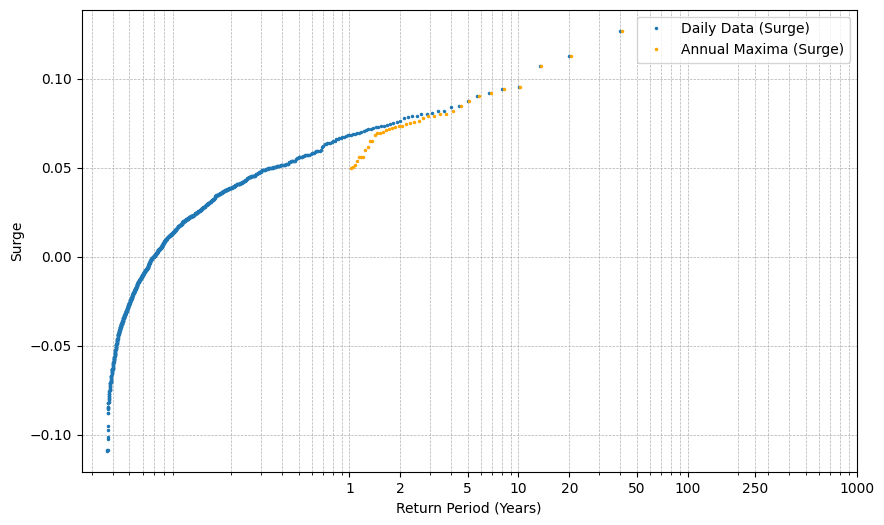

C:\Users\user\Victor\Trabajo\NoEstacionario\Python\ExtremePOT_Correction\extremecorrection.py:135: RuntimeWarning: divide by zero encountered in divide
  return_perd_values_gev = 1/(1-stats.genextreme.cdf(x_values_gev,self.gev_parameters[2], loc=self.gev_parameters[0], scale=self.gev_parameters[1]))


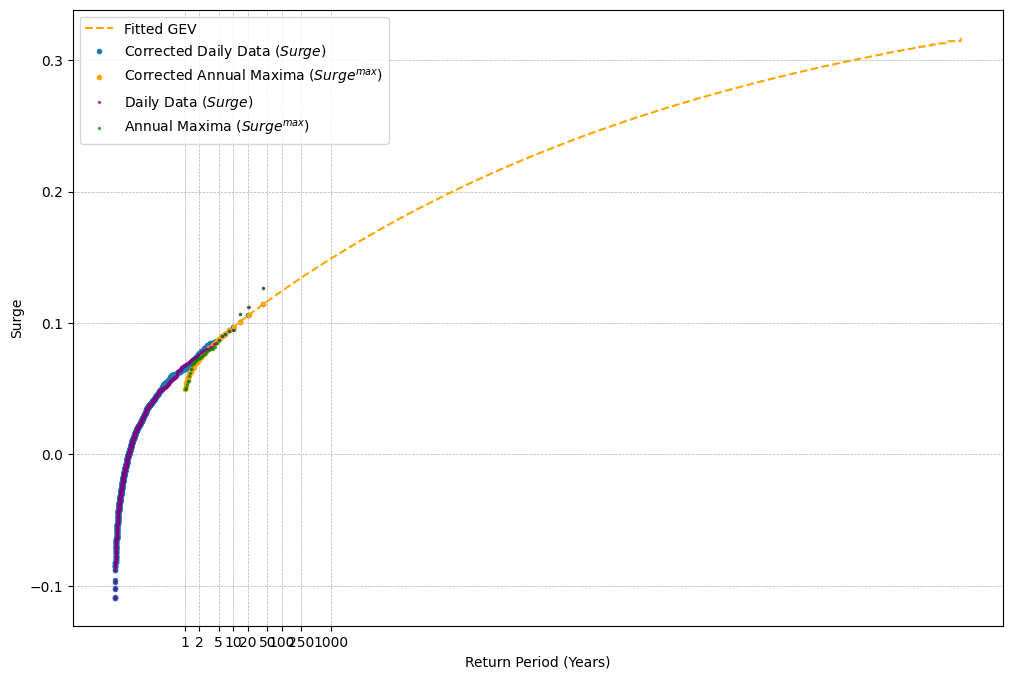

In [26]:
from ExtremePOT_Correction.extremecorrection import ExtremeCorrection

# for idx_wt, wt in enumerate(wt_range):
idx_wt=0
extremecorr = ExtremeCorrection(dict_ss[idx_wt], frequency=n_return_period[idx_wt], data_var='Surge')
extremecorr.return_period_plot()

# output_dir = "Figuras/WT_Hs"
# os.makedirs(output_dir, exist_ok=True)

fig = extremecorr.return_period_plot_corrected(without_corr=True)  # Generar gráfico

# fig.savefig(f"{output_dir}/ReturnPeriod_WT{idx_wt}.png", dpi=200, bbox_inches='tight')
# extremecorr.plot_ts()

# Corrección de extremos usando máximos anuales para cada Weather Type

Corrección de la serie simulada teniendo en cuenta como extremos los Máximos Anuales. Esta corrección sigue los siguientes pasos:

- Paso 1: Calculo de los máximos anuales históricos para cada WT
- Paso 2: Ajuste de la GEV para los Máximos Anuales históricos para cada WT
- Paso 3: Corrección de los datos históricos para cada WT
- Paso 4: Corrección de los datos Simulados para cada WT

Aparte de estos pasos, una vez hecha la corrección hay distintos subapartados que incluyen los gráficos de los periodos de retorno de los máximos corregidos.

Aunque se han calculado ya ciertas cosas en los apartados anteriores de este notebook, se vuelven a calcular todo (por ejemplo, los máximos históricos anuales) para que este todo bien esquematizado todo con los pasos que hay que seguir para este algoritmo de corrección.

## Ajuste al máximo anual histórico

### Paso 1: Calculo de los máximos anuales históricos para cada WT

Calculamos los máximos anuales para cada WT de los datos históricos.

In [28]:
# dict_ss contains the data associated to each WT

# Dictionaries
max_data_hist = {}
max_idx_hist = {}
max_data_hist_sort = {}
max_idx_hist_sort = {}

# Obtaining annual maxima and indices associated
for wt in wt_range:
    max_data_hist[wt] = dict_ss[wt].groupby(["yyyy"], as_index=False)["Surge"].max()["Surge"].values
    max_idx_hist[wt] = dict_ss[wt].groupby(["yyyy"])["Surge"].idxmax().values
    max_data_hist_sort[wt] = np.sort(max_data_hist[wt])
    max_idx_hist_sort[wt] = np.argsort(max_data_hist[wt])

### Paso 2: Ajuste de la GEV para los Máximos Anuales históricos

In [97]:
shape_gev = {}
loc_gev = {}
scale_gev = {}

for wt in wt_range:
    shape_gev[wt], loc_gev[wt], scale_gev[wt] = stats.genextreme.fit(max_data_hist[wt], 0)

#### QQ plots

In [98]:
folder_path = f"Figuras/{variable}/AnnualMax/QQplots"
os.makedirs(folder_path, exist_ok=True)

for wt in wt_range:
    # Calcular cuantiles teóricos de la GPD ajustada
    n = len(max_data_hist[wt])
    probabilities = (np.arange(1, n + 1)) / (n+1)  # Probabilidades de los cuantiles empíricos
    gev_quantiles = stats.genextreme.ppf(probabilities, shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt])

    # Ordenar los datos observados para comparación con los cuantiles teóricos
    sorted_data = np.sort(max_data_hist[wt])

    # Crear el QQ-plot
    plt.figure(figsize=(7, 7))
    plt.scatter(gev_quantiles, sorted_data, label="Datos vs. GEV", alpha=0.7)
    plt.plot(gev_quantiles, gev_quantiles, 'r--', label="y = x (Referencia)")

    # Etiquetas
    plt.xlabel("Cuantiles Teóricos (GEV ajustada)")
    plt.ylabel("Cuantiles Empíricos (Datos)")
    # plt.title("QQ-plot: Ajuste de la GEV a los Datos")
    plt.legend()
    plt.grid()
    plt.savefig(f"{folder_path}/QQPlot_WT{wt}.png", dpi=200)
    plt.close()

Hay que mejorar el ajuste de los Weather Types: 2,6,10,11,12,15

### Paso 3: Corrección Extremal de los datos históricos

Importamos la función negativa de verosimilitud y derivada de la función cuantil para la GEV estacionaria (util para calcular la hessiana y los intervalos de confianza de la GEV) que se encuentran en el archivo `utils.py`

In [99]:
from ExtremePOT_Correction.utils import dq_gev, nll_gev

A la vez que hacemos la corrección extremal, también calculamos las probabilidades empíricas y los periodos de retorno asociados

In [100]:
# -- Dictionaries to store results --
ecdf_annmax_probs_hist = {}
hs_annmax_corrected_hist= {}
hs_corrected_hist = {}
ecdf_annmax_probs_corrected_hist = {}
T_ev_corrected_hist = {}
ecdf_pt_probs_corrected_hist = {}
T_pt_corrected_hist = {}
x_values_gev_hist = {}
fitted_return_perd_values_gev_hist = {}
T_pot_hist = {}
ecdf_pt_probs_wt_hist = {}
T_pt_wt_hist = {}


quanval = 0.95
dqgev = {}
hessians_gev = {} 
invI0_gev = {} 
stdDq_gev = {}
stdup_gev = {}
stdlo_gev = {}


for wt in wt_range:
    # --- 1. Precompute / store repeated values in a variable ---
    peak_values = max_data_hist_sort[wt]
    daily_hs = dict_ss[wt]['Surge'].values
    n_peaks = len(peak_values)
    n_daily = len(daily_hs)
    
    # --- 2. Empirical peak probabilities + GEV quantiles ---
    aux_ecdf_pot_probs = np.arange(1, n_peaks + 1) / (n_peaks + 1)
    ecdf_annmax_probs_hist[wt] = aux_ecdf_pot_probs
    # GPD-corrected peaks
    corrected_peaks = stats.genextreme.ppf(aux_ecdf_pot_probs, shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt])
    hs_annmax_corrected_hist[wt] = corrected_peaks
    
    # --- 3. Vectorized correction of the daily data ---
    #     Only correct those daily Hs >= the first threshold peak; 
    #     below that, they remain as is. For values above the last peak, 
    #     we clamp them to the last corrected peak. Otherwise, we do a 
    #     linear interpolation between consecutive peaks.
    aux_hs_corrected = daily_hs.copy()  # copy original array
    
    if n_peaks > 1:
        # Create a boolean mask for values above the first “peak_values[0]”
        above_mask = aux_hs_corrected > peak_values[0]
        # Clip these “above” values so that anything larger than peak_values[-1]
        # is just pinned at peak_values[-1]. This replicates your code’s logic:
        #   daily_value >= last peak => daily_value = corrected_peaks[-1].
        clipped_vals = np.clip(aux_hs_corrected[above_mask], peak_values[0], peak_values[-1])
        
        # Interpolate them onto the corrected peak range
        # By default, np.interp returns the left/right endpoint values
        # for out-of-bounds data. Since we clipped above, no extrapolation needed.
        aux_hs_corrected[above_mask] = np.interp(
            clipped_vals,         # x-coords to interpolate
            peak_values,          # x-coords of data points
            corrected_peaks       # y-coords of data points
        )
    
    hs_corrected_hist[wt] = aux_hs_corrected
    
    # --- 4. Compute probabilities & return periods ---
    #     (Same as your original code, but using local variables 
    #      to make it more readable.)

    # GPD fit over a grid of x-values
    x_vals = np.linspace(corrected_peaks[0], corrected_peaks[-1], 1000)
    x_values_gev_hist[wt] = x_vals
    # Return period from GPD fit
    cdf_gev = stats.genextreme.cdf(x_vals, shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt])
    fitted_return_perd_values_gev_hist[wt] = 1.0 / (1.0 - cdf_gev) *(40/n_peaks)
    
    # Corrected peaks: re-check CDF and return periods
    cdf_corrected = stats.genextreme.cdf(
        stats.genextreme.ppf(aux_ecdf_pot_probs, shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]),
        shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]
    )
    ecdf_annmax_probs_corrected_hist[wt] = cdf_corrected
    T_ev_corrected_hist[wt] = 1.0 / (1.0 - cdf_corrected) *(40/n_peaks)
    
    # Daily corrected data
    ecdf_pt_probs_corrected = np.arange(1, n_daily + 1) / (n_daily + 1)
    ecdf_pt_probs_corrected_hist[wt] = ecdf_pt_probs_corrected
    T_pt_corrected_hist[wt] = 1.0 / (1.0 - ecdf_pt_probs_corrected) / n_return_period[wt] 
    
    # POT (uncorrected)
    T_pot_hist[wt] = 1.0 / (1.0 - aux_ecdf_pot_probs) *(40/n_peaks)
    
    # Daily data (uncorrected)
    ecdf_pt_probs_wt = np.arange(1, n_daily + 1) / (n_daily + 1)
    ecdf_pt_probs_wt_hist[wt] = ecdf_pt_probs_wt
    T_pt_wt_hist[wt] = 1.0 / (1.0 - ecdf_pt_probs_wt) / n_return_period[wt]

    # Confidence intervals
    # dqgev[wt] = dq_gev(ecdf_annmax_probs_hist[wt], xi=shape_gev, loc=loc_gev, sigma=scale_gev, wt=wt, quanval=quanval)
    dqgev[wt] = dq_gev(ecdf_annmax_probs_hist[wt], p=[loc_gev[wt], scale_gev[wt], shape_gev[wt]])
    # _,_,hessians_gev[wt] = loglikelihood_gev(peak_values, xi=shape_gev, loc=loc_gev, sigma=scale_gev, wt=wt)
    aux_fun = lambda x: nll_gev(max_data_hist[wt], x)
    hess = ndt.Hessian(aux_fun, step=1e-5)  # Añado el step para que no de problemas de inestabilidad
    hessians_gev[wt] = hess([loc_gev[wt], scale_gev[wt], shape_gev[wt]])
    invI0_gev[wt] = np.linalg.inv(hessians_gev[wt])

    stdDq_gev[wt] = np.sqrt(np.sum((dqgev[wt].T@invI0_gev[wt]) * dqgev[wt].T, axis=1)) # Es lo mismo 
    stdup_gev[wt] = hs_annmax_corrected_hist[wt] + stdDq_gev[wt]*stats.norm.ppf(1-(1-quanval)/2,0,1)
    stdlo_gev[wt] = hs_annmax_corrected_hist[wt] - stdDq_gev[wt]*stats.norm.ppf(1-(1-quanval)/2,0,1)

Maximos anuales sin corregir y GEV ajustada

In [101]:
folder_path = f"Figuras/{variable}/AnnualMax/CorrectionAnn_WT_Hs_EmpiricalData"
os.makedirs(folder_path, exist_ok=True)


# Gráfico
for wt in wt_range:
    fig = plt.figure(figsize=(12,8))
    ax= fig.add_subplot()
    ax.semilogx(fitted_return_perd_values_gev_hist[wt], np.sort(x_values_gev_hist[wt]), color = 'orange',linestyle='dashed', label='Fitted GEV')
    # ax.semilogx(T_pt_corrected_hist[wt], np.sort(hs_corrected_hist[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($H_s$)')
    # ax.semilogx(T_ev_corrected_hist[wt], stats.genextreme.ppf(ecdf_annmax_probs_hist[wt], shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima ($H_s$)')

    # Si representamos los datos sin corregir
    ax.semilogx(T_pot_hist[wt], max_data_hist_sort[wt], color="green", linewidth=0, marker='+',markersize=3, label='Annual Maxima')
    ax.semilogx(T_pt_wt_hist[wt], np.sort(dict_ss[wt]['Surge'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')


    # Confidence interval for fitted GEV
    ax.semilogx(T_ev_corrected_hist[wt], stdup_gev[wt], color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
    ax.semilogx(T_ev_corrected_hist[wt], stdlo_gev[wt], color = "black",linestyle='dotted')

    ax.set_xlabel("Return Periods (Years)")
    ax.set_ylabel("Hs")
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    ax.set_xlim(right=250)
    ax.legend()
    ax.grid()
    plt.savefig(f"{folder_path}/ReturnPeriod_{wt}.png", dpi=300)
    plt.close()
# plt.show()

### Paso 4: Corrección de los datos **Simulados** para cada WT

#### Carga de la serie simulada y manipulación de los datos

In [102]:
SS_LWT_dataset = xr.open_dataset("Datos\\DatosSimulados_10000y\\LWT_ss_sim.nc")
nsim = SS_LWT_dataset.n_sim.values

# Juntar los datos simulados
ss_simulated_data = np.array([])
year_simulated = np.array([])
month_simulated = np.array([])
day_simulated = np.array([])
wt_simulated_data = np.array([])
for i in range(len(nsim)):
    ss_simulated_data = np.concatenate([ss_simulated_data, SS_LWT_dataset.surge[i].values[:-1]])
    year_simulated = np.concatenate([year_simulated, SS_LWT_dataset.time.values[:-1].astype('datetime64[Y]').astype(int) + 1970  + 100*i])
    month_simulated = np.concatenate([month_simulated, SS_LWT_dataset.time.values[:-1].astype('datetime64[M]').astype(int) % 12 + 1])
    day_simulated = np.concatenate([day_simulated, (SS_LWT_dataset.time.values[:-1].astype('datetime64[D]') - SS_LWT_dataset.time.values[:-1].astype('datetime64[M]')).astype(int) + 1])
    wt_simulated_data = np.concatenate([wt_simulated_data, SS_LWT_dataset.LWT[:-1,i].values])   # LWT indices: (time, n_sim)

# Cambiar el indice del WT para que se asemeje a los datos historicos (rango WT0-WT35, nuevos datos rango WT1-WT36)
wt_simulated_data = wt_simulated_data -1

# Dataframe with the simulated data
simulated_df = pd.DataFrame({'Surge': ss_simulated_data,
                            'year': year_simulated,
                            'month': month_simulated,
                            'day': day_simulated,
                            'wt': wt_simulated_data})

# nan values if appears
nan_values_idx = np.where(np.isnan(ss_simulated_data))[0]

# Dictionary with simulated data per WT
dict_hs_sim = {}
for idx_wt, wt in enumerate(wt_range):
    dict_hs_sim[idx_wt] = simulated_df[:][simulated_df['wt'] == idx_wt]
    # dict_hs_sim[idx_wt] = dict_hs_sim[idx_wt].dropna(subset=["Hs"])
    # dict_hs_sim[idx_wt]['Surge'] = dict_hs_sim[idx_wt]['Surge'].fillna(0)  # No necesario, no hay NAs

# Yearly maxima
hsmax_data_sim = {}         # Máximos anuales
max_idx_sim = {}            # Índices de los máximos
hsmax_data_sorted_sim = {}  # Diccionario para los datos ordenados
sorted_max_idx_sim = {}     # Índices de los máximos ordenados
max_idx_sim_40years = {}    # Máximos en el rango de la serie histórica

# Point-in-time data
hspt_sim = {}
hspt_sort_sim = {}

for idx_wt, wt in enumerate(wt_range):
    hsmax_data_sim[idx_wt] = dict_hs_sim[idx_wt].groupby(["year"], as_index=False)["Surge"].max()   # Máximo anual Hs para cada WT
    max_idx_sim[idx_wt] = dict_hs_sim[idx_wt].groupby(["year"])["Surge"].idxmax().values            # Índice del máximo anual por WT
    hsmax_data_sorted_sim[idx_wt] = np.sort(hsmax_data_sim[idx_wt]['Surge'])                        # Máximos anuales ordenados
    sorted_max_idx_sim[idx_wt] = np.argsort(hsmax_data_sim[idx_wt]['Surge'])                        # Índice de los maximos ordenados

    max_idx_sim_40years[idx_wt] = {}
    for i_year in range(10000//40):
        # Indice del máximo anual por WT cada 40 años
        max_idx_sim_40years[idx_wt][i_year] = dict_hs_sim[idx_wt][(2000+40*i_year< dict_hs_sim[idx_wt]['year']) & (dict_hs_sim[idx_wt]['year'] <= 2000+40*(i_year+1))].groupby(["year"])["Surge"].idxmax().values           
    
    hspt_sim[idx_wt] = dict_hs_sim[idx_wt]['Surge'].values
    hspt_sort_sim[idx_wt] = np.sort(dict_hs_sim[idx_wt]['Surge'].values)

#### Corrección de los datos simulados para cada WT

In [103]:
# -- Dictionaries to store results --
ecdf_annmax_probs_sim = {}
hs_annmax_corrected_sim= {}
hs_corrected_sim = {}
ecdf_annmax_probs_corrected_sim = {}
T_ev_corrected_sim = {}
ecdf_pt_probs_corrected_sim = {}
T_pt_corrected_sim = {}
x_values_gev_sim = {}
fitted_return_perd_values_gev_sim = {}
T_pot_sim = {}
ecdf_pt_probs_wt_sim= {}
T_pt_wt_sim= {}

quanval = 0.95
dqgev_sim = {}
hessians_gev_sim = {} 
invI0_gev_sim = {} 
stdDq_gev_sim = {}
stdup_gev_sim = {}
stdlo_gev_sim = {}

for wt in wt_range:
    # --- 1. Precompute / store repeated values in a variable ---
    peak_values = np.sort(hsmax_data_sim[wt]['Surge'].values)
    daily_hs = dict_hs_sim[wt]['Surge'].values
    n_peaks = len(peak_values)
    n_daily = len(daily_hs)
    
    # --- 2. Empirical peak probabilities + GEV quantiles ---
    aux_ecdf_pot_probs = np.arange(1, n_peaks + 1) / (n_peaks + 1)
    ecdf_annmax_probs_sim[wt] = aux_ecdf_pot_probs
    # GPD-corrected peaks
    corrected_peaks = stats.genextreme.ppf(aux_ecdf_pot_probs, shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt])
    hs_annmax_corrected_sim[wt] = corrected_peaks
    
    # --- 3. Vectorized correction of the daily data ---
    #     Only correct those daily Hs >= the first threshold peak; 
    #     below that, they remain as is. For values above the last peak, 
    #     we clamp them to the last corrected peak. Otherwise, we do a 
    #     linear interpolation between consecutive peaks.
    aux_hs_corrected = daily_hs.copy()  # copy original array
    
    if n_peaks > 1:
        # Create a boolean mask for values above the first “peak_values[0]”
        above_mask = aux_hs_corrected > peak_values[0]
        # Clip these “above” values so that anything larger than peak_values[-1]
        # is just pinned at peak_values[-1]. This replicates your code’s logic:
        #   daily_value >= last peak => daily_value = corrected_peaks[-1].
        clipped_vals = np.clip(aux_hs_corrected[above_mask], peak_values[0], peak_values[-1])
        
        # Interpolate them onto the corrected peak range
        # By default, np.interp returns the left/right endpoint values
        # for out-of-bounds data. Since we clipped above, no extrapolation needed.
        aux_hs_corrected[above_mask] = np.interp(
            clipped_vals,         # x-coords to interpolate
            peak_values,          # x-coords of data points
            corrected_peaks       # y-coords of data points
        )
    
    hs_corrected_sim[wt] = aux_hs_corrected
    
    # --- 4. Compute probabilities & return periods ---
    #     (Same as your original code, but using local variables 
    #      to make it more readable.)

    # GPD fit over a grid of x-values
    x_vals = np.linspace(corrected_peaks[0], corrected_peaks[-1], 1000)
    x_values_gev_sim[wt] = x_vals
    # Return period from GPD fit
    cdf_gev = stats.genextreme.cdf(x_vals, shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt])
    fitted_return_perd_values_gev_sim[wt] = 1.0 / (1.0 - cdf_gev) *(40/len(max_data_hist[wt]))#(10000/n_peaks)
    
    # Corrected peaks: re-check CDF and return periods
    cdf_corrected = stats.genextreme.cdf(
        stats.genextreme.ppf(aux_ecdf_pot_probs, shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]),
        shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]
    )
    ecdf_annmax_probs_corrected_sim[wt] = cdf_corrected
    T_ev_corrected_sim[wt] = 1.0 / (1.0 - cdf_corrected) *(40/len(max_data_hist[wt]))#(10000/n_peaks)
    
    # Daily corrected data
    ecdf_pt_probs_corrected = np.arange(1, n_daily + 1) / (n_daily + 1)
    ecdf_pt_probs_corrected_sim[wt] = ecdf_pt_probs_corrected
    T_pt_corrected_sim[wt] = 1.0 / (1.0 - ecdf_pt_probs_corrected) / n_return_period[wt] 
    
    # POT (uncorrected)
    T_pot_sim[wt] = 1.0 / (1.0 - aux_ecdf_pot_probs) *(40/len(max_data_hist[wt]))#(10000/n_peaks)
    
    # Daily data (uncorrected)
    ecdf_pt_probs_wt = np.arange(1, n_daily + 1) / (n_daily + 1)
    ecdf_pt_probs_wt_sim[wt] = ecdf_pt_probs_wt
    T_pt_wt_sim[wt] = 1.0 / (1.0 - ecdf_pt_probs_wt) / n_return_period[wt]

    # Confidence intervals
    dqgev_sim[wt] = dq_gev(ecdf_annmax_probs_sim[wt], p=[loc_gev[wt], scale_gev[wt], shape_gev[wt]])
    aux_fun = lambda x: nll_gev(max_data_hist[wt], x)
    hess = ndt.Hessian(aux_fun, step=1e-4)  # Añado el step para que no de problemas de inestabilidad
    hessians_gev_sim[wt] = hess([loc_gev[wt], scale_gev[wt], shape_gev[wt]])
    invI0_gev_sim[wt] = np.linalg.inv(hessians_gev_sim[wt])

    stdDq_gev_sim[wt] = np.sqrt(np.sum((dqgev_sim[wt].T@invI0_gev_sim[wt]) * dqgev_sim[wt].T, axis=1)) # Es lo mismo 
    stdup_gev_sim[wt] = hs_annmax_corrected_sim[wt] + stdDq_gev_sim[wt]*stats.norm.ppf(1-(1-quanval)/2,0,1)
    stdlo_gev_sim[wt] = hs_annmax_corrected_sim[wt] - stdDq_gev_sim[wt]*stats.norm.ppf(1-(1-quanval)/2,0,1)

Periodos de retorno empíricos

In [104]:
folder_path = f"Figuras/{variable}/AnnualMax/Simulated_CorrectionAnn_WT_SS"
os.makedirs(folder_path, exist_ok=True)


# Gráfico
for wt in wt_range:
    fig = plt.figure(figsize=(12,8))
    ax= fig.add_subplot()
    ax.semilogx(fitted_return_perd_values_gev_sim[wt], np.sort(x_values_gev_sim[wt]), color = 'orange',linestyle='dashed', label='Fitted GEV')
    ax.semilogx(T_pt_corrected_sim[wt], np.sort(hs_corrected_sim[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($SS$)')
    ax.semilogx(T_ev_corrected_sim[wt], stats.genextreme.ppf(ecdf_annmax_probs_sim[wt], shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima ($SS$)')

    # Si representamos los datos sin corregir
    ax.semilogx(T_pot_sim[wt], np.sort(hsmax_data_sim[wt]['Surge'].values), color="green", linewidth=0, marker='+',markersize=3, label='Annual Maxima')
    ax.semilogx(T_pt_wt_sim[wt], np.sort(dict_hs_sim[wt]['Surge'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

    # Confidence Interval
    ax.semilogx(T_ev_corrected_sim[wt], stdup_gev_sim[wt], color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
    ax.semilogx(T_ev_corrected_sim[wt], stdlo_gev_sim[wt], color = "black",linestyle='dotted')


    ax.set_xlabel("Return Periods (Years)")
    ax.set_ylabel("Storm Surge")
    ax.set_xscale('log')
    ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
    ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    # ax.set_xlim(right=10100)
    ax.legend()
    ax.grid()
    ax.set_xlim(left=0.01, right=11000)
    ax.set_ylim(bottom=-1, top=simulated_df["Surge"].max()+0.5)
    plt.savefig(f"{folder_path}/ReturnPeriod_{wt}.png", dpi=300)
    plt.close()
# plt.show()

### Serie historica con bandas de confianza y serie simulada cada 40 años

In [105]:
new_max_idx_sim_100 = {}
annual_maxima_corrected_sim_100 = {}
T_ecdf_annual_maxima_sim_100 = {}
ecdf_annual_maxima_sim_100 = {}

annual_maxima_nocorrected_sim_100 = {}
ecdf_annual_maxima_sim_100_nocorr = {}
T_ecdf_annual_maxima_sim_100_nocorr = {}

# 40 by 40 years
for wt in wt_range:
    new_max_idx_sim_100[wt] = {}
    annual_maxima_corrected_sim_100[wt] = {}
    ecdf_annual_maxima_sim_100[wt] = {}
    T_ecdf_annual_maxima_sim_100[wt] = {}
    # Sin corregir
    annual_maxima_nocorrected_sim_100[wt] = {}
    ecdf_annual_maxima_sim_100_nocorr[wt] = {}
    T_ecdf_annual_maxima_sim_100_nocorr[wt] = {}
    for i_year in range(len(max_idx_sim_40years[wt])):
        new_max_idx_sim_100[wt][i_year] = dict_hs_sim[wt]['Surge'][~np.isnan(dict_hs_sim[wt]['Surge'].values)].index.get_indexer(max_idx_sim_40years[wt][i_year])
        annual_maxima_corrected_sim_100[wt][i_year] = hs_corrected_sim[wt][new_max_idx_sim_100[wt][i_year]]
        ecdf_annual_maxima_sim_100[wt][i_year] = np.arange(1,len(annual_maxima_corrected_sim_100[wt][i_year])+1)/(len(annual_maxima_corrected_sim_100[wt][i_year])+1)
        T_ecdf_annual_maxima_sim_100[wt][i_year] = 1/(1-ecdf_annual_maxima_sim_100[wt][i_year])*(40/len(new_max_idx_sim_100[wt][i_year]))
        # Sin corregir
        annual_maxima_nocorrected_sim_100[wt][i_year] = dict_hs_sim[wt]['Surge'][~np.isnan(dict_hs_sim[wt]['Surge'].values)][max_idx_sim_40years[wt][i_year]].values
        ecdf_annual_maxima_sim_100_nocorr[wt][i_year] = np.arange(1,len(annual_maxima_nocorrected_sim_100[wt][i_year])+1)/(len(annual_maxima_nocorrected_sim_100[wt][i_year])+1)
        T_ecdf_annual_maxima_sim_100_nocorr[wt][i_year] = 1/(1-ecdf_annual_maxima_sim_100_nocorr[wt][i_year])*(40/len(max_idx_sim_40years[wt][i_year]))

De 40 en 40 años corrigiendo los datos simulados

In [106]:
folder_path = f"Figuras/{variable}/AnnualMax/HistoricalData_40ySimulatedAll"
os.makedirs(folder_path, exist_ok=True)


for wt in wt_range:
    
    fig = plt.figure(figsize=(16,8))
    ax1= fig.add_subplot(121)   
    ax2= fig.add_subplot(122)   

    # ax.semilogx(fitted_return_perd_values_gpd[wt], np.sort(x_values_gpd[wt]), color = 'orange',linestyle='dashed', label='Adjusted GPD')
    # ax.semilogx(T_pt_corrected[wt], np.sort(hs_wt0_corrected[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($P$)')
    # ax.semilogx(T_ev_corrected[wt], qgpd(ecdf_pot_probs[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($P$)')

    # Si representamos los datos sin corregir
    # ax.semilogx(T_pot[wt], picos[wt][picos[wt] > thresholds[wt]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
    # ax.semilogx(T_pt_wt[wt], np.sort(dict_hs[wt]['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

    # Serie simulada 40 por 40 años CORREGIDA
    max2 = []
    max2.append(np.max(annual_maxima_corrected_sim_100[wt][0]))
    ax2.semilogx(T_ecdf_annual_maxima_sim_100[wt][0], np.sort(annual_maxima_corrected_sim_100[wt][0]), color = "tab:gray", alpha = 0.1, label="Corrected Simulated Data by 40 Years")
    for i_year in range(1,len(max_idx_sim_40years[wt])):
        max2.append(np.max(annual_maxima_corrected_sim_100[wt][i_year]))
        ax2.semilogx(T_ecdf_annual_maxima_sim_100[wt][i_year], np.sort(annual_maxima_corrected_sim_100[wt][i_year]), color = "tab:gray", alpha = 0.1)

    # Serie simulada 40 por 40 años SIN CORREGIR
    max1 = []
    max1.append(np.max(annual_maxima_nocorrected_sim_100[wt][0]))
    ax1.semilogx(T_ecdf_annual_maxima_sim_100_nocorr[wt][0], np.sort(annual_maxima_nocorrected_sim_100[wt][0]), color = "tab:gray", alpha = 0.1, label="No Corrected Simulated Data by 40 Years")
    for i_year in range(1,len(max_idx_sim_40years[wt])):
        max1.append(np.max(annual_maxima_nocorrected_sim_100[wt][i_year]))
        ax1.semilogx(T_ecdf_annual_maxima_sim_100_nocorr[wt][i_year], np.sort(annual_maxima_nocorrected_sim_100[wt][i_year]), color = "tab:gray", alpha = 0.1)


    # Annual Return Periods
    # ax.semilogx(T_ev_corrected_hist[wt], stats.genextreme.ppf(ecdf_annmax_probs_hist[wt], shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]), 
    #             color = "#FF0000", linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
    ax1.semilogx(fitted_return_perd_values_gev_hist[wt], np.sort(x_values_gev_hist[wt]), color = "tab:red",linestyle='dashed', label=f'Adjusted GEV')
    ax1.semilogx(T_pot_hist[wt], max_data_hist_sort[wt], color="tab:blue", linewidth=0, marker='o',markersize=4, label='Annual Maxima')
    
    ax2.semilogx(fitted_return_perd_values_gev_hist[wt], np.sort(x_values_gev_hist[wt]), color = "tab:red",linestyle='dashed', label=f'Adjusted GEV')
    ax2.semilogx(T_pot_hist[wt], max_data_hist_sort[wt], color="tab:blue", linewidth=0, marker='o',markersize=4, label='Annual Maxima')
    
    # Confidence intervals
    ax1.semilogx(T_ev_corrected_hist[wt], stdup_gev[wt], color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
    ax1.semilogx(T_ev_corrected_hist[wt], stdlo_gev[wt], color = "black",linestyle='dotted')
    
    ax2.semilogx(T_ev_corrected_hist[wt], stdup_gev[wt], color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
    ax2.semilogx(T_ev_corrected_hist[wt], stdlo_gev[wt], color = "black",linestyle='dotted')
    
    

    ax1.set_xlabel("Return Periods (Years)")
    ax1.set_ylabel("Storm Surge")
    ax1.set_xscale('log')
    ax1.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
    ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    leg1 = ax1.legend(loc='upper left', ncol=2)
    for lh in leg1.legend_handles:
        lh.set_alpha(1)
    ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax1.set_ylim(bottom = -0.1, top = np.max([np.max(max1), np.max(max2)])+0.1)
    ax1.set_xlim(right=50)
    ax1.set_title("No Corrected")


    ax2.set_xlabel("Return Periods (Years)")
    ax2.set_ylabel("Storm Surge")
    ax2.set_xscale('log')
    ax2.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
    ax2.get_xaxis().set_major_formatter(plt.ScalarFormatter())
    leg2 = ax2.legend(loc='upper left', ncol=2)
    for lh in leg2.legend_handles:
        lh.set_alpha(1)
    ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax2.set_ylim(bottom = -0.1, top = np.max([np.max(max1), np.max(max2)])+0.1)
    ax2.set_xlim(right=50)
    ax2.set_title("Corrected")

    fig.tight_layout()
    plt.savefig(f"{folder_path}/ReturnPeriod_{wt}.png", dpi=300)
    plt.close()
    # plt.show()

### Ajuste GEV a la serie histórica sin dividir por WT

In [107]:
max_all_data_hist = df_surge.groupby("yyyy")["Surge"].max().values
max_all_data_hist_sort = np.sort(max_all_data_hist)

Ajuste GEV:

In [108]:
shape_gev_all, loc_gev_all, scale_gev_all = stats.genextreme.fit(max_all_data_hist, 0)
(shape_gev_all, loc_gev_all, scale_gev_all)

(0.0076051913267944325, 0.2855748164504557, 0.055547078222507484)

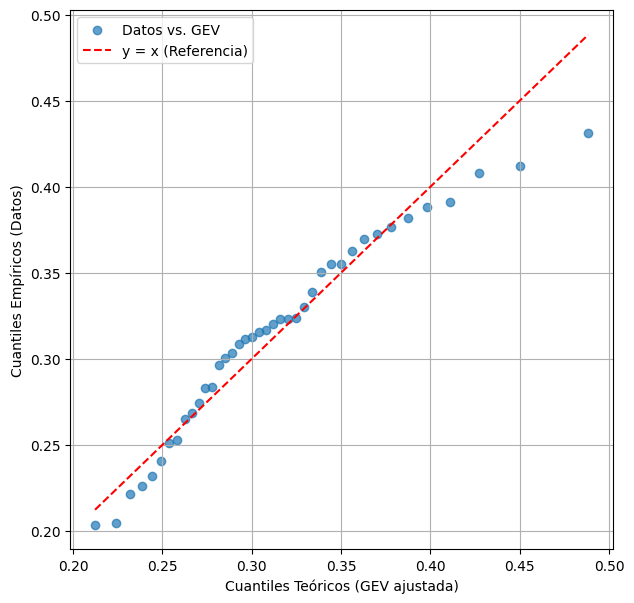

In [109]:
folder_path = f"Figuras/{variable}/AnnualMax"

n = len(max_all_data_hist)
probabilities = (np.arange(1, n + 1)) / (n+1)  # Probabilidades de los cuantiles empíricos
gev_quantiles = stats.genextreme.ppf(probabilities, shape_gev_all, loc=loc_gev_all, scale=scale_gev_all)

# Crear el QQ-plot
plt.figure(figsize=(7, 7))
plt.scatter(gev_quantiles, max_all_data_hist_sort, label="Datos vs. GEV", alpha=0.7)
plt.plot(gev_quantiles, gev_quantiles, 'r--', label="y = x (Referencia)")

# Etiquetas
plt.xlabel("Cuantiles Teóricos (GEV ajustada)")
plt.ylabel("Cuantiles Empíricos (Datos)")
# plt.title("QQ-plot: Ajuste de la GEV a los Datos")
plt.legend()
plt.grid()
plt.savefig(f"{folder_path}/QQPlot_All.png", dpi=200)
plt.show()
plt.close()

Corrección en la serie histórica

In [129]:
# --- 1. Precompute / store repeated values in a variable ---
peak_values = max_all_data_hist_sort
daily_hs = df_surge['Surge'].values
n_peaks = len(peak_values)
n_daily = len(daily_hs)

# --- 2. Empirical peak probabilities + GEV quantiles ---
aux_ecdf_pot_probs = np.arange(1, n_peaks + 1) / (n_peaks + 1)
ecdf_annmax_probs_hist_all = aux_ecdf_pot_probs
# GPD-corrected peaks
corrected_peaks = stats.genextreme.ppf(aux_ecdf_pot_probs, shape_gev_all, loc=loc_gev_all, scale=scale_gev_all)
hs_annmax_corrected_hist_all = corrected_peaks

# --- 3. Vectorized correction of the daily data ---
#     Only correct those daily Hs >= the first threshold peak; 
#     below that, they remain as is. For values above the last peak, 
#     we clamp them to the last corrected peak. Otherwise, we do a 
#     linear interpolation between consecutive peaks.
aux_hs_corrected = daily_hs.copy()  # copy original array

if n_peaks > 1:
    # Create a boolean mask for values above the first “peak_values[0]”
    above_mask = aux_hs_corrected > peak_values[0]
    # Clip these “above” values so that anything larger than peak_values[-1]
    # is just pinned at peak_values[-1]. This replicates your code’s logic:
    #   daily_value >= last peak => daily_value = corrected_peaks[-1].
    clipped_vals = np.clip(aux_hs_corrected[above_mask], peak_values[0], peak_values[-1])
    
    # Interpolate them onto the corrected peak range
    # By default, np.interp returns the left/right endpoint values
    # for out-of-bounds data. Since we clipped above, no extrapolation needed.
    aux_hs_corrected[above_mask] = np.interp(
        clipped_vals,         # x-coords to interpolate
        peak_values,          # x-coords of data points
        corrected_peaks       # y-coords of data points
    )

hs_corrected_hist_all = aux_hs_corrected

# --- 4. Compute probabilities & return periods ---
#     (Same as your original code, but using local variables 
#      to make it more readable.)

# GPD fit over a grid of x-values
x_vals = np.linspace(corrected_peaks[0], corrected_peaks[-1], 1000)
x_values_gev_hist_all = x_vals
# Return period from GPD fit
cdf_gev = stats.genextreme.cdf(x_vals, shape_gev_all, loc=loc_gev_all, scale=scale_gev_all)
fitted_return_perd_values_gev_hist_all = 1.0 / (1.0 - cdf_gev) *(40/n_peaks)

# Corrected peaks: re-check CDF and return periods
cdf_corrected = stats.genextreme.cdf(
    stats.genextreme.ppf(aux_ecdf_pot_probs, shape_gev_all, loc=loc_gev_all, scale=scale_gev_all),
    shape_gev_all, loc=loc_gev_all, scale=scale_gev_all
)
ecdf_annmax_probs_corrected_hist_all = cdf_corrected
T_ev_corrected_hist_all = 1.0 / (1.0 - cdf_corrected) *(40/n_peaks)

# Daily corrected data
ecdf_pt_probs_corrected = np.arange(1, n_daily + 1) / (n_daily + 1)
ecdf_pt_probs_corrected_hist_all = ecdf_pt_probs_corrected
T_pt_corrected_hist_all = 1.0 / (1.0 - ecdf_pt_probs_corrected) / 365.25

# POT (uncorrected)
T_pot_hist_all = 1.0 / (1.0 - aux_ecdf_pot_probs) *(40/n_peaks)

# Daily data (uncorrected)
ecdf_pt_probs_wt = np.arange(1, n_daily + 1) / (n_daily + 1)
ecdf_pt_probs_wt_hist_all = ecdf_pt_probs_wt
T_pt_wt_hist_all = 1.0 / (1.0 - ecdf_pt_probs_wt) / 365.25

# Confidence intervals
# dqgev[wt] = dq_gev(ecdf_annmax_probs_hist[wt], xi=shape_gev, loc=loc_gev, sigma=scale_gev, wt=wt, quanval=quanval)
dqgev_all = dq_gev(ecdf_annmax_probs_hist_all, p=[loc_gev_all, scale_gev_all, shape_gev_all])
# _,_,hessians_gev[wt] = loglikelihood_gev(peak_values, xi=shape_gev, loc=loc_gev, sigma=scale_gev, wt=wt)
aux_fun = lambda x: nll_gev(max_all_data_hist, x)
hess = ndt.Hessian(aux_fun)
hessians_gev_all = hess([loc_gev_all, scale_gev_all, shape_gev_all])
invI0_gev_all = np.linalg.inv(hessians_gev_all)

stdDq_gev_all = np.sqrt(np.sum((dqgev_all.T@invI0_gev_all) * dqgev_all.T, axis=1)) # Es lo mismo 
stdup_gev_all = hs_annmax_corrected_hist_all + stdDq_gev_all*stats.norm.ppf(1-(1-quanval)/2,0,1)
stdlo_gev_all = hs_annmax_corrected_hist_all - stdDq_gev_all*stats.norm.ppf(1-(1-quanval)/2,0,1)

Corrección en la serie simulada

In [112]:
hs_simulated_data = simulated_df.fillna(0)  # En caso de haber NA 
# Obtaining annual maxima and indices associated
max_all_data_sim = hs_simulated_data.groupby(["year"], as_index=False)["Surge"].max()["Surge"].values
max_all_idx_sim = hs_simulated_data.groupby(["year"])["Surge"].idxmax().values
max_all_data_sim_sort = np.sort(max_all_data_sim)
max_all_idx_sim_sort = np.argsort(max_all_data_sim)

In [122]:
# --- 1. Precompute / store repeated values in a variable ---
peak_values = max_all_data_sim_sort
daily_hs = hs_simulated_data['Surge'].values
n_peaks = len(peak_values)
n_daily = len(daily_hs)

# # --- 2. Empirical peak probabilities + GEV quantiles ---
aux_ecdf_pot_probs = np.arange(1, n_peaks + 1) / (n_peaks + 1)
ecdf_annmax_probs_sim_all = aux_ecdf_pot_probs
# # GPD-corrected peaks
corrected_peaks = stats.genextreme.ppf(aux_ecdf_pot_probs, shape_gev_all, loc=loc_gev_all, scale=scale_gev_all)
hs_annmax_corrected_sim_all = corrected_peaks

# --- 3. Vectorized correction of the daily data ---
#     Only correct those daily Hs >= the first threshold peak; 
#     below that, they remain as is. For values above the last peak, 
#     we clamp them to the last corrected peak. Otherwise, we do a 
#     linear interpolation between consecutive peaks.
aux_hs_corrected = daily_hs.copy()  # copy original array

if n_peaks > 1:
    # Create a boolean mask for values above the first “peak_values[0]”
    above_mask = aux_hs_corrected > peak_values[0]
    # Clip these “above” values so that anything larger than peak_values[-1]
    # is just pinned at peak_values[-1]. This replicates your code’s logic:
    #   daily_value >= last peak => daily_value = corrected_peaks[-1].
    clipped_vals = np.clip(aux_hs_corrected[above_mask], peak_values[0], peak_values[-1])
    
    # Interpolate them onto the corrected peak range
    # By default, np.interp returns the left/right endpoint values
    # for out-of-bounds data. Since we clipped above, no extrapolation needed.
    aux_hs_corrected[above_mask] = np.interp(
        clipped_vals,         # x-coords to interpolate
        peak_values,          # x-coords of data points
        corrected_peaks       # y-coords of data points
    )

hs_corrected_sim_all = aux_hs_corrected

# --- 4. Compute probabilities & return periods ---
#     (Same as your original code, but using local variables 
#      to make it more readable.)

# GPD fit over a grid of x-values
x_vals = np.linspace(corrected_peaks[0], corrected_peaks[-1], 1000)
x_values_gev_sim_all = x_vals
# Return period from GPD fit
cdf_gev = stats.genextreme.cdf(x_vals, shape_gev_all, loc=loc_gev_all, scale=scale_gev_all)
fitted_return_perd_values_gev_sim_all = 1.0 / (1.0 - cdf_gev) #*(40/len(max_all_data_hist_sort))#(10000/n_peaks)

# Corrected peaks: re-check CDF and return periods
cdf_corrected = stats.genextreme.cdf(
    stats.genextreme.ppf(aux_ecdf_pot_probs, shape_gev_all, loc=loc_gev_all, scale=scale_gev_all),
    shape_gev_all, loc=loc_gev_all, scale=scale_gev_all
)
ecdf_annmax_probs_corrected_sim_all = cdf_corrected
T_ev_corrected_sim_all = 1.0 / (1.0 - cdf_corrected) #*(40/len(max_all_data_hist_sort))#(10000/n_peaks)

# Daily corrected data
ecdf_pt_probs_corrected = np.arange(1, n_daily + 1) / (n_daily + 1)
ecdf_pt_probs_corrected_sim_all = ecdf_pt_probs_corrected
T_pt_corrected_sim_all = 1.0 / (1.0 - ecdf_pt_probs_corrected) / 365.25

# POT (uncorrected)
T_pot_sim_all = 1.0 / (1.0 - aux_ecdf_pot_probs) #*(40/len(max_all_data_hist_sort))#(10000/n_peaks)

# Daily data (uncorrected)
ecdf_pt_probs_wt = np.arange(1, n_daily + 1) / (n_daily + 1)
ecdf_pt_probs_wt_sim_all = ecdf_pt_probs_wt
T_pt_wt_sim_all = 1.0 / (1.0 - ecdf_pt_probs_wt) / 365.25

# Confidence intervals
dqgev_sim_all = dq_gev(ecdf_annmax_probs_sim_all, p=[loc_gev_all, scale_gev_all, shape_gev_all])
aux_fun = lambda x: nll_gev(max_all_data_hist, x)
hess = ndt.Hessian(aux_fun)
hessians_gev_sim_all = hess([loc_gev_all, scale_gev_all, shape_gev_all])
invI0_gev_sim_all = np.linalg.inv(hessians_gev_sim_all)

stdDq_gev_sim_all = np.sqrt(np.sum((dqgev_sim_all.T@invI0_gev_sim_all) * dqgev_sim_all.T, axis=1)) # Es lo mismo 
stdup_gev_sim_all = hs_annmax_corrected_sim_all + stdDq_gev_sim_all*stats.norm.ppf(1-(1-quanval)/2,0,1)
stdlo_gev_sim_all = hs_annmax_corrected_sim_all - stdDq_gev_sim_all*stats.norm.ppf(1-(1-quanval)/2,0,1)

Máximos cada 40 años

In [123]:
max_idx_sim_40years_all = {}
for i_year in range(10000//40):
    max_idx_sim_40years_all[i_year] = hs_simulated_data[(2000+40*i_year< hs_simulated_data['year']) & (hs_simulated_data['year'] <= 2000+40*(i_year+1))].groupby(["year"])["Surge"].idxmax().values

In [124]:
# 40 by 40 years
new_max_idx_sim_100_all = {}
annual_maxima_corrected_sim_100_all = {}
ecdf_annual_maxima_sim_100_all = {}
T_ecdf_annual_maxima_sim_100_all = {}
# Sin corregir
annual_maxima_nocorrected_sim_100_all = {}
ecdf_annual_maxima_sim_100_nocorr_all = {}
T_ecdf_annual_maxima_sim_100_nocorr_all = {}
for i_year in range(10000//40):
    new_max_idx_sim_100_all[i_year] = hs_simulated_data["Surge"].index.get_indexer(max_idx_sim_40years_all[i_year])
    annual_maxima_corrected_sim_100_all[i_year] = hs_corrected_sim_all[new_max_idx_sim_100_all[i_year]]
    ecdf_annual_maxima_sim_100_all[i_year] = np.arange(1,len(annual_maxima_corrected_sim_100_all[i_year])+1)/(len(annual_maxima_corrected_sim_100_all[i_year])+1)
    T_ecdf_annual_maxima_sim_100_all[i_year] = 1/(1-ecdf_annual_maxima_sim_100_all[i_year])*(40/len(new_max_idx_sim_100_all[i_year]))
    # Sin corregir
    annual_maxima_nocorrected_sim_100_all[i_year] = hs_simulated_data["Surge"][max_idx_sim_40years_all[i_year]].values
    ecdf_annual_maxima_sim_100_nocorr_all[i_year] = np.arange(1,len(annual_maxima_nocorrected_sim_100_all[i_year])+1)/(len(annual_maxima_nocorrected_sim_100_all[i_year])+1)
    T_ecdf_annual_maxima_sim_100_nocorr_all[i_year] = 1/(1-ecdf_annual_maxima_sim_100_nocorr_all[i_year])*(40/len(max_idx_sim_40years_all[i_year]))

### Periodos de retorno máximos anuales corregidos juntando todos los WT. 

Usar los datos corregidos de la simulación corregidos para cada WT para pintar los máximos anuales de la serie completa.

In [125]:
aux_hs_corrected_sim_all = []
aux_year_corrected_sim_all = []
aux_month_corrected_sim_all = []
aux_day_corrected_sim_all = []
aux_wt_corrected_sim_all = []
for wt in wt_range:
    aux_hs_corrected_sim_all.extend(hs_corrected_sim[wt])
    aux_year_corrected_sim_all.extend(dict_hs_sim[wt]['year'].values)
    aux_month_corrected_sim_all.extend(dict_hs_sim[wt]['month'].values)
    aux_day_corrected_sim_all.extend(dict_hs_sim[wt]['day'].values)
    aux_wt_corrected_sim_all.extend(dict_hs_sim[wt]['wt'].values)

# ESTOS NO SE HAN CORREGIDO, EN CASO DE QUE HAYA ALGUN WT QUE NO SE USE LA CORRECCIÓN
# for wt in unique_rwt[-4:]:
#     aux_hs_corrected_sim_all.extend(dict_hs_sim[wt]['Hs'].values)
#     aux_year_corrected_sim_all.extend(dict_hs_sim[wt]['year'].values)
#     aux_month_corrected_sim_all.extend(dict_hs_sim[wt]['month'].values)
#     aux_day_corrected_sim_all.extend(dict_hs_sim[wt]['day'].values)
#     aux_wt_corrected_sim_all.extend(dict_hs_sim[wt]['wt'].values)

df_corrected_simulation = pd.DataFrame({
    'Surge_corr': aux_hs_corrected_sim_all, 
    'year': aux_year_corrected_sim_all, 
    'month': aux_month_corrected_sim_all, 
    'day': aux_day_corrected_sim_all, 
    'wt': aux_wt_corrected_sim_all, 
})


In [126]:
maximos_anuales_corregidos_all = df_corrected_simulation.groupby(["year"], as_index=False)["Surge_corr"].max()["Surge_corr"].values
ecdf_maximos_anuales_corregidos_all = np.arange(1,len(maximos_anuales_corregidos_all)+1)/(len(maximos_anuales_corregidos_all)+1)
T_empirical_maximos_anuales_corregidos_all = 1/(1-ecdf_maximos_anuales_corregidos_all)

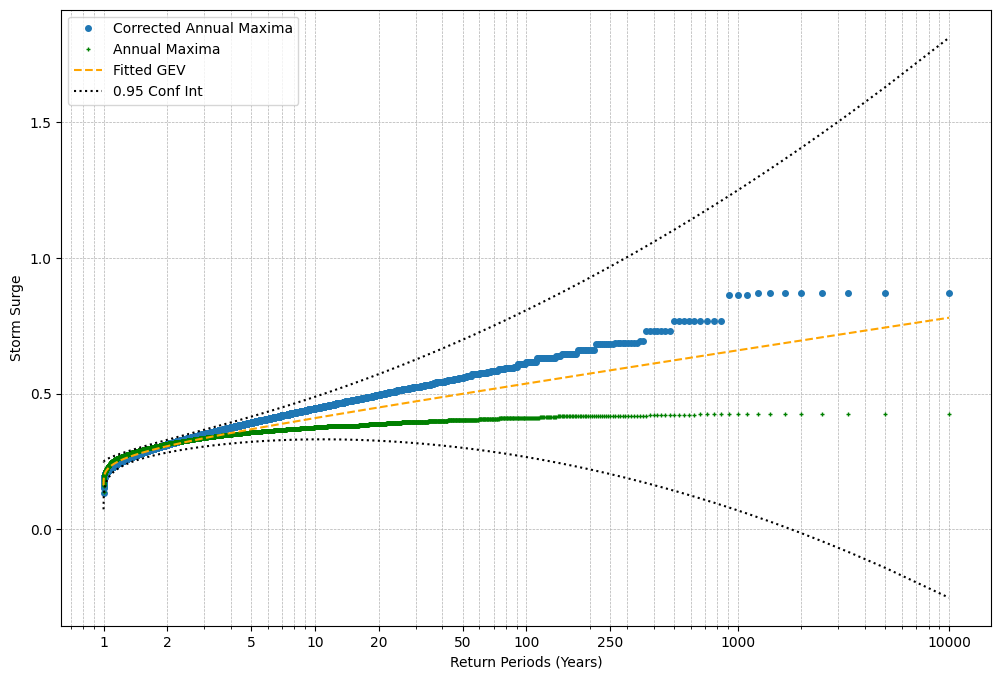

In [127]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.semilogx(T_empirical_maximos_anuales_corregidos_all, np.sort(maximos_anuales_corregidos_all), color="tab:blue", linewidth=0, marker='o',markersize=4, label='Corrected Annual Maxima')
# ax.semilogx(T_empirical_maximos_anuales_corregidos_all, max_all_data_sim_sort, color="green", linewidth=0, marker='+',markersize=4, label='Annual Maxima')
ax.semilogx(T_pot_sim_all, max_all_data_sim_sort, color="green", linewidth=0, marker='+',markersize=3, label='Annual Maxima')


ax.semilogx(fitted_return_perd_values_gev_sim_all, np.sort(x_values_gev_sim_all), color = 'orange',linestyle='dashed', label='Fitted GEV')
# Confidence Interval
ax.semilogx(T_ev_corrected_sim_all, stdup_gev_sim_all, color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
ax.semilogx(T_ev_corrected_sim_all, stdlo_gev_sim_all, color = "black",linestyle='dotted')

ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.set_xlabel("Return Periods (Years)")
ax.set_ylabel("Storm Surge")
ax.set_xscale('log')
ax.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax.get_xaxis().set_major_formatter(plt.ScalarFormatter())
ax.legend()
plt.savefig(f"{folder_path}/CorrectedAllWT_ReturnPeriod.png", dpi=300)
plt.show()
plt.close()

Dividido por años

In [128]:
# 40 by 40 years
new_max_idx_sim_100_all = {}
annual_maxima_corrected_sim_100_all_wt = {}
ecdf_annual_maxima_sim_100_all_wt = {}
T_ecdf_annual_maxima_sim_100_all_wt = {}
# Sin corregir
annual_maxima_nocorrected_sim_100_all = {}
ecdf_annual_maxima_sim_100_nocorr_all = {}
T_ecdf_annual_maxima_sim_100_nocorr_all = {}
for i_year in range(10000//40):
    new_max_idx_sim_100_all[i_year] = hs_simulated_data["Surge"].index.get_indexer(max_idx_sim_40years_all[i_year])

    annual_maxima_corrected_sim_100_all_wt[i_year] = maximos_anuales_corregidos_all[40*i_year:40*(i_year+1)]
    ecdf_annual_maxima_sim_100_all_wt[i_year] = np.arange(1,len(annual_maxima_corrected_sim_100_all_wt[i_year])+1)/(len(annual_maxima_corrected_sim_100_all_wt[i_year])+1)
    T_ecdf_annual_maxima_sim_100_all_wt[i_year] = 1/(1-ecdf_annual_maxima_sim_100_all_wt[i_year])*(40/len(max_idx_sim_40years_all[i_year]))
    # Sin corregir
    annual_maxima_nocorrected_sim_100_all[i_year] = hs_simulated_data["Surge"][max_idx_sim_40years_all[i_year]].values
    ecdf_annual_maxima_sim_100_nocorr_all[i_year] = np.arange(1,len(annual_maxima_nocorrected_sim_100_all[i_year])+1)/(len(annual_maxima_nocorrected_sim_100_all[i_year])+1)
    T_ecdf_annual_maxima_sim_100_nocorr_all[i_year] = 1/(1-ecdf_annual_maxima_sim_100_nocorr_all[i_year])*(40/len(max_idx_sim_40years_all[i_year]))

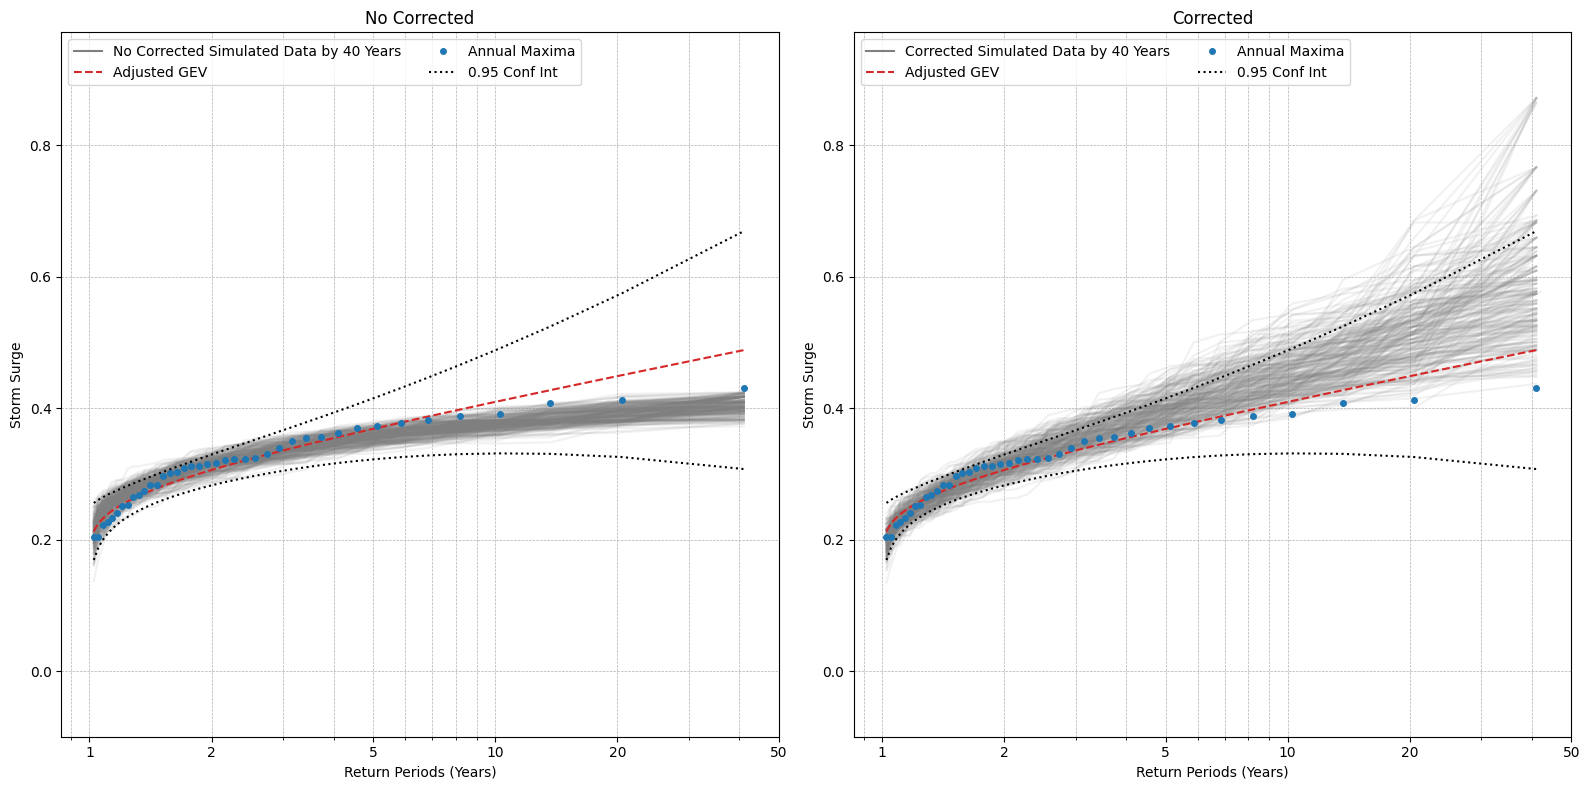

In [130]:
fig = plt.figure(figsize=(16,8))
ax1= fig.add_subplot(121)   
ax2= fig.add_subplot(122)   

# ax.semilogx(fitted_return_perd_values_gpd[wt], np.sort(x_values_gpd[wt]), color = 'orange',linestyle='dashed', label='Adjusted GPD')
# ax.semilogx(T_pt_corrected[wt], np.sort(hs_wt0_corrected[wt]), linewidth=0, marker='o',markersize=3, label='Corrected Daily Data ($P$)')
# ax.semilogx(T_ev_corrected[wt], qgpd(ecdf_pot_probs[wt], xi=xi[wt], threshold=thresholds[wt], sigma=sigma[wt]), color = 'orange',linewidth=0, marker='o',markersize=3, label=r'Corrected POT ($P$)')

# Si representamos los datos sin corregir
# ax.semilogx(T_pot[wt], picos[wt][picos[wt] > thresholds[wt]], color="green", linewidth=0, marker='+',markersize=3, label='POT')
# ax.semilogx(T_pt_wt[wt], np.sort(dict_hs[wt]['Hs'].values), color="purple", linewidth=0, marker='+',markersize=3, label='Daily Data')

# Serie simulada 40 por 40 años CORREGIDA
max2 = []
max2.append(np.max(annual_maxima_corrected_sim_100_all_wt[0]))
ax2.semilogx(T_ecdf_annual_maxima_sim_100_all_wt[0], np.sort(annual_maxima_corrected_sim_100_all_wt[0]), color = "tab:gray", alpha = 0.1, label="Corrected Simulated Data by 40 Years")
for i_year in range(1,10000//40):
    max2.append(np.max(annual_maxima_corrected_sim_100_all_wt[i_year]))
    ax2.semilogx(T_ecdf_annual_maxima_sim_100_all_wt[i_year], np.sort(annual_maxima_corrected_sim_100_all_wt[i_year]), color = "tab:gray", alpha = 0.1)

# Serie simulada 40 por 40 años SIN CORREGIR
max1 = []
max1.append(np.max(annual_maxima_nocorrected_sim_100_all[0]))
ax1.semilogx(T_ecdf_annual_maxima_sim_100_nocorr_all[0], np.sort(annual_maxima_nocorrected_sim_100_all[0]), color = "tab:gray", alpha = 0.1, label="No Corrected Simulated Data by 40 Years")
for i_year in range(1,10000//40):
    max1.append(np.max(annual_maxima_nocorrected_sim_100_all[i_year]))
    ax1.semilogx(T_ecdf_annual_maxima_sim_100_nocorr_all[i_year], np.sort(annual_maxima_nocorrected_sim_100_all[i_year]), color = "tab:gray", alpha = 0.1)


# Annual Return Periods
# ax.semilogx(T_ev_corrected_hist[wt], stats.genextreme.ppf(ecdf_annmax_probs_hist[wt], shape_gev[wt], loc=loc_gev[wt], scale=scale_gev[wt]), 
#             color = "#FF0000", linewidth=0, marker='o',markersize=3, label=r'Corrected Annual Maxima')
ax1.semilogx(fitted_return_perd_values_gev_hist_all, np.sort(x_values_gev_hist_all), color = "tab:red",linestyle='dashed', label=f'Adjusted GEV')
ax1.semilogx(T_pot_hist_all, max_all_data_hist_sort, color="tab:blue", linewidth=0, marker='o',markersize=4, label='Annual Maxima')

ax2.semilogx(fitted_return_perd_values_gev_hist_all, np.sort(x_values_gev_hist_all), color = "tab:red",linestyle='dashed', label=f'Adjusted GEV')
ax2.semilogx(T_pot_hist_all, max_all_data_hist_sort, color="tab:blue", linewidth=0, marker='o',markersize=4, label='Annual Maxima')

# Confidence intervals
ax1.semilogx(T_ev_corrected_hist_all, stdup_gev_all, color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
ax1.semilogx(T_ev_corrected_hist_all, stdlo_gev_all, color = "black",linestyle='dotted')

ax2.semilogx(T_ev_corrected_hist_all, stdup_gev_all, color = "black",linestyle='dotted', label=f'{quanval} Conf Int')
ax2.semilogx(T_ev_corrected_hist_all, stdlo_gev_all, color = "black",linestyle='dotted')



ax1.set_xlabel("Return Periods (Years)")
ax1.set_ylabel("Storm Surge")
ax1.set_xscale('log')
ax1.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax1.get_xaxis().set_major_formatter(plt.ScalarFormatter())
leg1 = ax1.legend(loc='upper left', ncol=2)
for lh in leg1.legend_handles:
    lh.set_alpha(1)
ax1.grid(True, which="both", linestyle="--", linewidth=0.5)
ax1.set_ylim(bottom = -0.1, top = np.max([np.max(max1), np.max(max2)])+0.1)
ax1.set_xlim(right=50)
ax1.set_title("No Corrected")


ax2.set_xlabel("Return Periods (Years)")
ax2.set_ylabel("Storm Surge")
ax2.set_xscale('log')
ax2.set_xticks([1, 2, 5, 10, 20, 50, 100, 250, 1000, 10000])
ax2.get_xaxis().set_major_formatter(plt.ScalarFormatter())
leg2 = ax2.legend(loc='upper left', ncol=2)
for lh in leg2.legend_handles:
    lh.set_alpha(1)
ax2.grid(True, which="both", linestyle="--", linewidth=0.5)
ax2.set_ylim(bottom = -0.1, top = np.max([np.max(max1), np.max(max2)])+0.1)
ax2.set_xlim(right=50)
ax2.set_title("Corrected")

fig.tight_layout()
# plt.savefig(f"{folder_path}/HistoricalData_40ySimulatedAll_ReturnPeriod_All.png", dpi=300)
plt.savefig(f"{folder_path}/HistoricalData_40ySimulatedAll_ReturnPeriod_JointWT.png", dpi=300)
plt.show()
plt.close()